# Eric Kofoid Assignment 5

In [3]:
library(fpp)

Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: fma
Loading required package: tseries
Loading required package: expsmooth
Loading required package: lmtest


## 1a)

* Mathematical Transformation - use this when the variation in seasons changes, when the YOY change gets bigger or smaller with each year.
* Calendar Transformation - use this when the monthly or weekly frequency don't have exact same number of days observed in each time-frame. Months don't have same number of days and weeks for a business don't always have same number of days (holidays).
* Population Transformation - use this when focusing in on geographical areas since the population in those areas changes over time. Comparing Kansas today to Kansas 50 years ago at a raw number will look drastically different, but looking at it from per capita (per 1000) will make it more consistent.
* Inflation Transformation - this one is pretty obvious. If you want to compare dollars today to dollars 10 years, have to adjust for inflation.

When dealing with a new data set, I always plot out the raw data first. Understand the base data too, what exactly is it measuring, is it measuring population or money (then probably could consider those types of Transformations). Is it varying YOY in the peaks/troughs.

## 1b)

Any time I will be using data about people over time, I would think that population transformation should be considered. Any time I use data that tracks sales over time, mathematical transformations might need to be considered. Of course if it is money over time, inflation transformation.

My "pigs" data that I have been using is monthly, so right off it is possible that calendar transformations may add value.

In the Aussie trinkets data from Assignment 3 makes perfect sense that we applied log (mathematical) transformation since the seasonal peaks had quite a bit of variation in them.

AirPassengers might have been able to have 2 different transformations. Mathematical because of the variation in the season values and Population because the US population increased over time as well.

## 2) Getting Started

First, examine the data itself. Do I see trend, seasonality, cycles. In the AirPassengers, there is clearly a strong trend and varying seasonality. Because of the varying seasonality, I suspect that I can apply mathematical transformation to the data to stabalize the variance. The log function does in fact level out seasonal variance. So I will use that in the rest of my examination.

Next thing to check for in our time-series is the stationarity. Just by looking at the plot of the AirPassengers it is definitely not stationary. It has trend and seasonality. I can also use an ACF plot. The ACF plot of AirPassengers does not drop to zero quickly, it is slowly descreasing, but will take many lags before it gets down to zero. So maybe  differencing will make the data stationary? When looking at the ACF plot of the difference in AirPassengers, it is still not white noise. There are many values that fall outside the 95% limit. I can also use the Box-Ljung test against the difference. In this case the p-value is extremely small <.05 which means the result is statistically significant and we therefore reject the null hypothesis that the result is white noise, meaning this data is still autocorrelated. So maybe the second order differencing will get us to stationary. The plot of the diff(diff(ap)) looks very close the same as just the diff(ap). So differencing alone is not going to make this data stationary.

This data is very seasonal, so I am going to check out seasonal differencing. First, I will seasonally adjust it. Again the ACF of the seasonally adjusted data still shows that it is slowly going down and way out of the confidence interval, which means the data is still not stationary.

So, lets identify what auto.arima says is our best fit model.
The auto function says we have seasonality (the second set of parens). The seasonality can be explained with (0, 1, 1) which means no Auto Regression is applied (p). 1 order of difference is applied (d). MA(1) is applied

## Examining Data
Clearly there is trend and seasonality as seen in the decomposition of the data.

This means the data is not stationary.

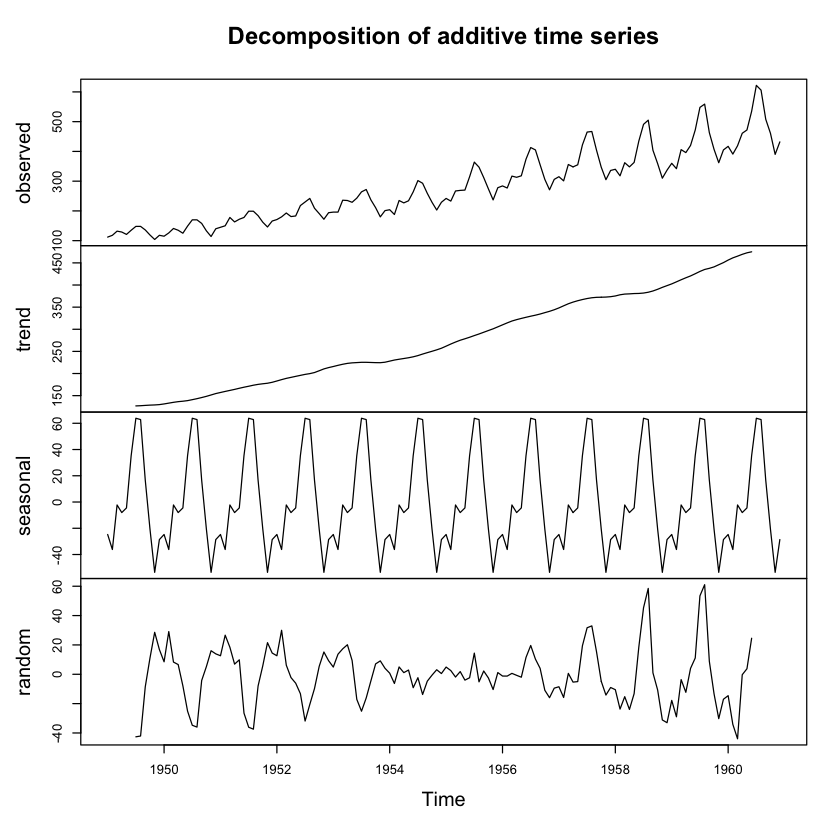

In [13]:
ap = AirPassengers
plot(decompose(ap))

## Dig Little Deeper
Since there seems to be seasonal variance, may need to apply mathematical transformation here.

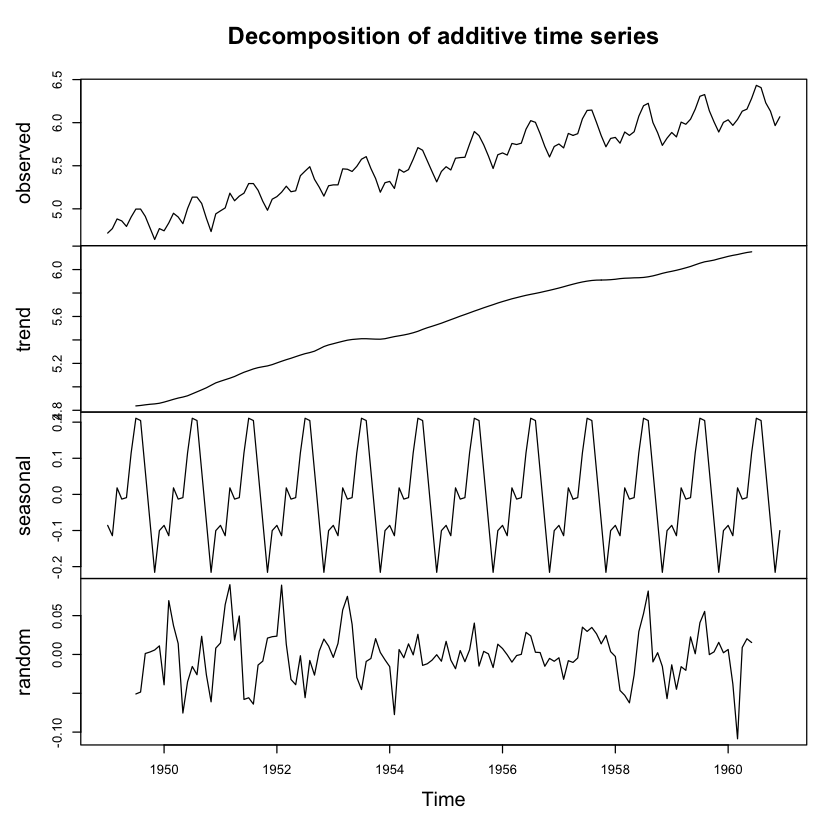

In [16]:
ap_log = log(ap)
plot(decompose(ap_log))

## Let's look at Differencing

The DF test shows that with first order differencing we can reject the null hypo that the data is non-stationary, statistically significant p-value < 0.05. So it seems d=1 in ARIMA model will help us.

In [116]:
ap_diff = diff(ap_log)

adf.test(ap_diff, alternative="stationary")

Warning message in adf.test(ap_diff, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  ap_diff
Dickey-Fuller = -6.4313, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


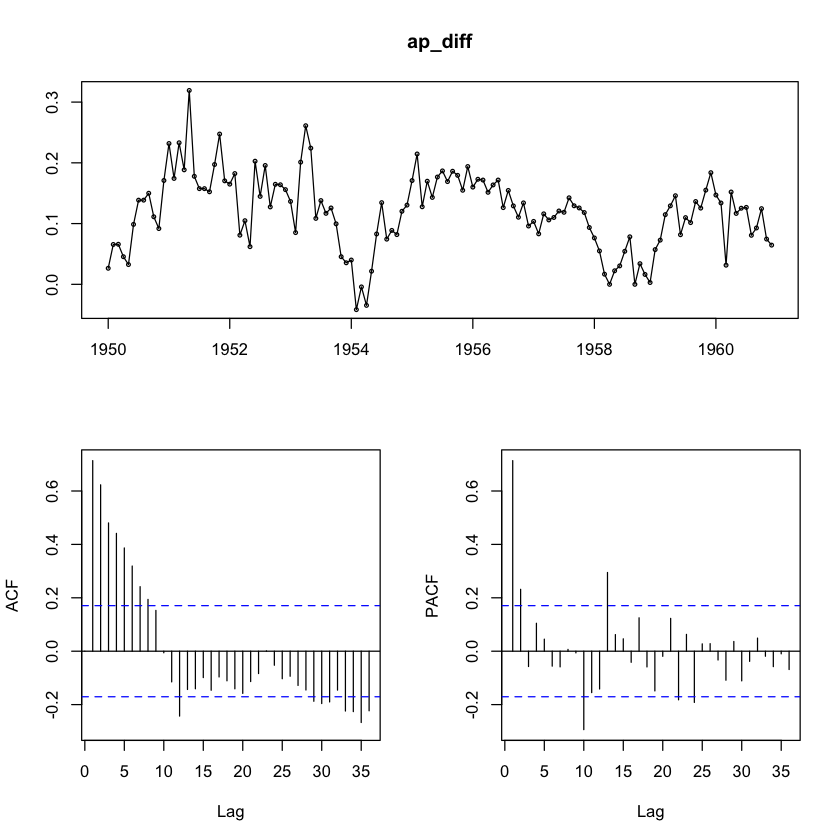

In [115]:
tsdisplay(ap_diff)

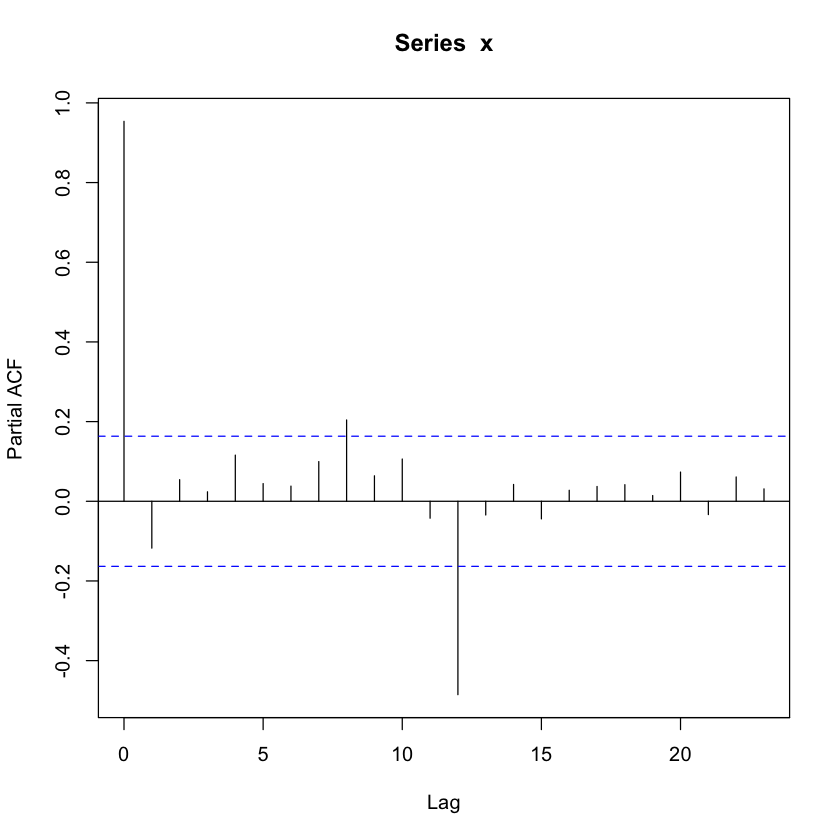

In [110]:
Pacf(ap_log)

## Let's see what auto ARIMA gives us

Since we know there is seasonality, I set the seasonal=TRUE.

Non-Seasonal part:
p = 0, 
d = 1
q = 1

In [83]:
aa = auto.arima(ap_log, seasonal=TRUE)
summary(aa)

Series: ap_log 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


In [84]:
Arima(ap_log, order=c(0, 1, 1), list(order=c(0, 1, 1), period = 12))

Series: ap_log 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

In [100]:
Arima(ap_log, order=c(0, 1, 1), list(order=c(0, 1, 1), period=12))

Series: ap_log 
ARIMA(0,1,2)(0,1,1)[12]                    

Coefficients:
          ma1      ma2     sma1
      -0.3961  -0.0397  -0.5590
s.e.   0.0859   0.0851   0.0732

sigma^2 estimated as 0.001379:  log likelihood=244.81
AIC=-481.62   AICc=-481.3   BIC=-470.12

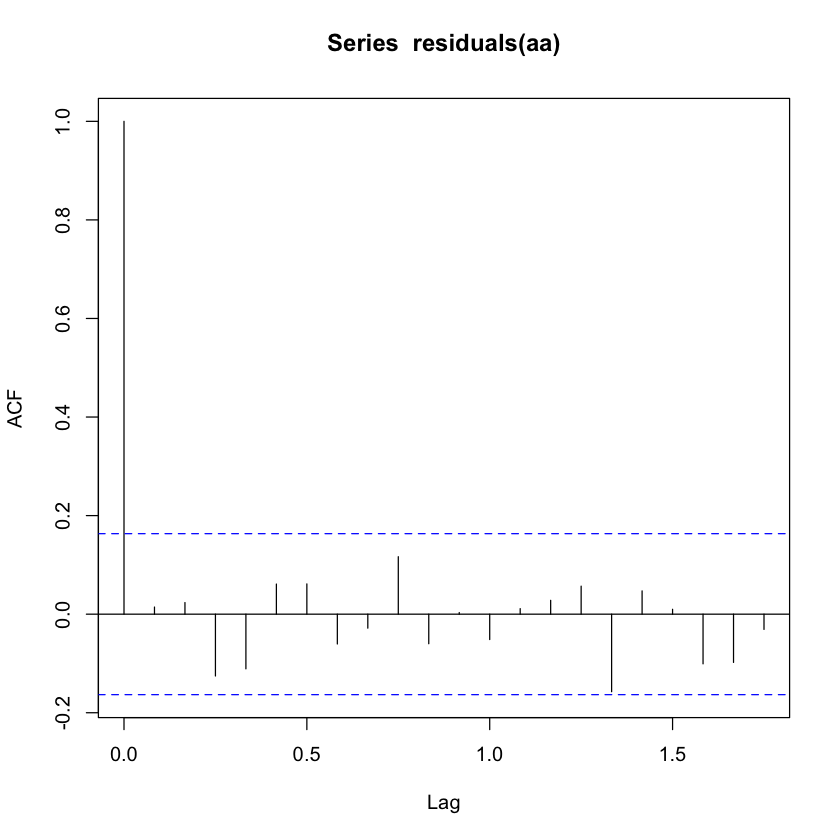

In [101]:
acf(residuals(aa))

## Revert results back to normal

In [120]:
future_exp = forecast(aa, 36)

# Convert Mean back
future_exp$mean = exp(future_exp$mean)
# Convert Upper back
future_exp$upper = exp(future_exp$upper)
# Convert Lower back
future_exp$lower = exp(future_exp$lower)
# Convert Original ts back
future_exp$x=exp(future_exp$x)

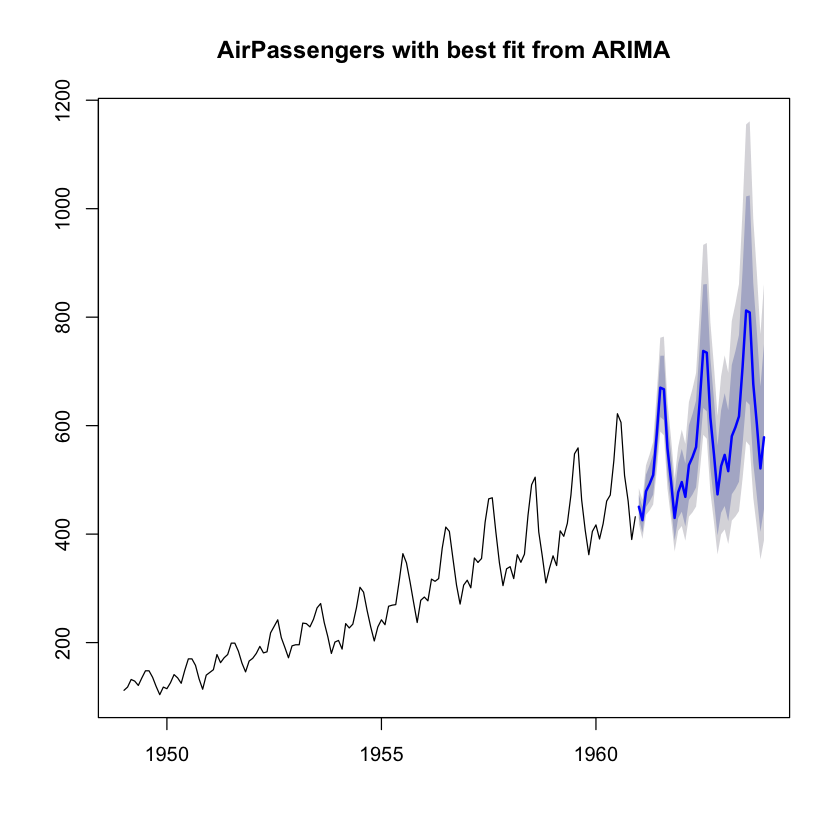

In [121]:
plot(future_exp, main="AirPassengers with best fit from ARIMA")